In [1]:
import pandas as pd
import numpy as np
import copernicusmarine as cm
import xgboost as xgb
import matplotlib.pyplot as plt

# XGboost with more features

Goal of this notebook is to do more modelling by incorporating extra datasets.

In [4]:
bathymetry_dataset_id = "cmems_mod_glo_phy_my_0.083deg_static"
carbon_dataset_id = "dataset-carbon-rep-monthly"
salinity_dataset_id = "cmems_obs-mob_glo_phy-sss_my_multi_P1M"
oxygen_dataset_id = 'cmems_mod_glo_bgc-bio_anfc_0.25deg_P1M-m'
chlorophyl_dataset_id = 'cmems_mod_glo_bgc-pft_anfc_0.25deg_P1M-m'
chemicals_dataset_id = 'cmems_mod_glo_bgc-nut_anfc_0.25deg_P1M-m'
chl_color_dataset = "cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M"

In [5]:
cp_df = pd.read_pickle('carbon-pisces-merged.pk')

In [7]:
salt_df = pd.read_pickle('salt-10-21-glob.pk')
salt_df.reset_index(inplace=True)
salt_df = salt_df[['latitude', 'longitude', 'dos','sos']].loc[salt_df.latitude>=-80].copy()

In [8]:
def long_to_x(long):
    return int(16*(long+180))

def lat_to_y(lat):
    return int(16*(lat+80))


def x_to_long(x):
    return (x/16)-180

def y_to_lat(y):
    return (y/16)-80

In [9]:
salt_df['x'] = salt_df.longitude.apply(long_to_x)
salt_df['y'] = salt_df.latitude.apply(lat_to_y)
cp_df['x'] = cp_df.longitude.apply(long_to_x)
cp_df['y'] = cp_df.latitude.apply(lat_to_y)

## Merging datasets 

I'm going to start by replacing longitude and latitude with integers

In [12]:
salt_df

,latitude,longitude,dos,sos,x,y
230400,-79.9375,-179.9375,NaN,NaN,1,1
230401,-79.9375,-179.8125,NaN,NaN,3,1
230402,-79.9375,-179.6875,NaN,NaN,5,1
230403,-79.9375,-179.5625,NaN,NaN,7,1
230404,-79.9375,-179.4375,NaN,NaN,9,1
...,...,...,...,...,...,...
4147195,89.9375,179.4375,NaN,NaN,5751,2719
4147196,89.9375,179.5625,NaN,NaN,5753,2719
4147197,89.9375,179.6875,NaN,NaN,5755,2719
4147198,89.9375,179.8125,NaN,NaN,5757,2719


All of the data we will use is going into a dictionary - this is going to speed up the merging process.

Once the data has moved from dataframe to dictionary we compute averages to obtain extra datapoints.

In [13]:
salt_dict = {}
for r in list(salt_df[['x','y','dos','sos']].values):
    salt_dict[(int(r[0]),int(r[1]))] = r[2:]


salt_xmax = int(salt_df.x.max())
salt_ymax = int(salt_df.y.max())

# Creating new datapoints
for i in range(1,salt_xmax-2,2):
    for j in range(1,salt_ymax,2):
        tups = [(i,j),(i+2,j),(i,j+2),(i+2,j+2)]
        salt_dict[(i+1,j+1)] = sum([salt_dict[tup] for tup in tups])/4

In [15]:
coords_cp = []
for pair in cp_df[['longitude','latitude']].values:
    x = long_to_x(pair[0])
    y = lat_to_y(pair[1])
    coords_cp.append((int(x),int(y)))

In [20]:
cp_df['xy'] = coords_cp

In [16]:
xys_cp_salt = []
for xy in coords_cp:
    salt_vec = salt_dict[xy]
    if salt_vec[0]==salt_vec[0]:
        xys_cp_salt.append(xy)

In [29]:
cp_df = cp_df.loc[cp_df.xy.isin(xys_cp_salt)].copy()

In [25]:
len(xys_cp_salt)

1153604

In [27]:
salt_df.keys()

Index(['latitude', 'longitude', 'dos', 'sos', 'x', 'y'], dtype='object')

In [30]:
cp_df['sea_surface_density'] = [salt_dict[xy][0] for xy in cp_df.xy] 
cp_df['sea_surface_salinity'] = [salt_dict[xy][1] for xy in cp_df.xy] 

In [33]:
cols = ['latitude', 'longitude', 'fgco2', 'omega_ar', 'omega_ca', 'ph', 'spco2',
       'talk', 'tco2', 'fe', 'no3', 'po4', 'si','sea_surface_density',
         'sea_surface_salinity','chl', 'phyc']

In [35]:
cp_df[cols].to_pickle('pisces-carbon-salinity-10-21-global.pk')

In [36]:
cp_df = cp_df[cols].copy()

In [39]:
cp_df.loc[cp_df.latitude>=0].to_pickle('psc10-21-north.pk')
cp_df.loc[cp_df.latitude<0].to_pickle('psc10-21-south.pk')

## XGBoost

We can now run XGboost

In [40]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [41]:
Xy_train, Xy_test = train_test_split(cp_df,train_size = 0.2,shuffle = True, random_state = 1729)

In [44]:
merged_features = ['latitude', 'longitude', 'fgco2', 'omega_ar', 'omega_ca', 'ph', 'spco2',
       'talk', 'tco2', 'fe', 'no3', 'po4', 'si', 'sea_surface_density',
       'sea_surface_salinity']

MSE: 0.0004
RMSE: 0.0200
Feature Importances:
latitude: 0.05480397865176201
longitude: 0.02726687304675579
fgco2: 0.03994622826576233
omega_ar: 0.22952553629875183
omega_ca: 0.07001308351755142
ph: 0.022507013753056526
spco2: 0.04756898060441017
talk: 0.01175319030880928
tco2: 0.04877861961722374
fe: 0.07565794140100479
no3: 0.16143880784511566
po4: 0.023730972781777382
si: 0.038741931319236755
sea_surface_density: 0.06994987279176712
sea_surface_salinity: 0.07831694930791855


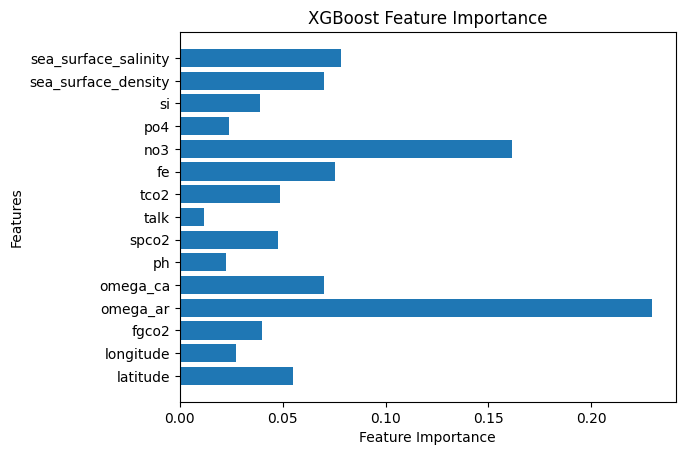

In [45]:
# Create an XGBoost classifier
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1,# Minimum sum of instance weight needed in a child
)

# Train the model
model.fit(Xy_train[merged_features], Xy_train.chl)

# Make predictions on the test set
y_pred = model.predict(Xy_test[merged_features])

# Evaluate the model - using MSE since we're doing regression
mse = mean_squared_error(y_pred=y_pred,y_true = Xy_test.chl)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

# Explore feature importance
feature_importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(merged_features, feature_importances):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.barh(merged_features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()


## Grid search

In [47]:
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1,# Minimum sum of instance weight needed in a child
)

param_grid = {
    'max_depth': [5, 7,10],
    'n_estimators': [100, 200,400]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error'

)

# Fit the grid search to the training data
grid_search.fit(Xy_train[merged_features], Xy_train.chl)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = xgb.XGBRegressor(**best_params)

# Train the best model
best_model.fit(Xy_train[merged_features], Xy_train.chl)

# Make predictions on the test set
y_pred_best = best_model.predict(Xy_test[merged_features])

# Evaluate the best model
mse_best = mean_squared_error(y_pred=y_pred_best,y_true = Xy_test.chl)
print(f"MSE with Best Parameters: {mse_best:.5f}")
print(f"RMSE with Best Parameters: {np.sqrt(mse_best):.5f}")

Best Parameters: {'max_depth': 10, 'n_estimators': 400}
MSE with Best Parameters: 0.00004
RMSE with Best Parameters: 0.00635


The chlorophyll values are very small - a more intuitive metric is simple mean absolute error as a percentage of the true value.

In [48]:
np.mean(((y_pred_best-Xy_test.chl)/Xy_test.chl).apply(abs))

0.058009331604863025

On average our predictions are off by about 6 percent.

Can also check how often our predictions are within 1 standard deviation of the correct value.

In [49]:
Xy_train.chl.std()

0.039463675707313114

In [50]:
ct = 0
for i,c in enumerate(y_pred_best):
    ct+=int(abs(Xy_test.chl.values[i]-c)<0.03934364190177824)

In [51]:
ct

919849

Our results are almost always within one standard deviation of the correct value.

In [52]:
proportion_within_one_std = ct/len(y_pred_best)
print(proportion_within_one_std)

0.9967113960151005


## Shap

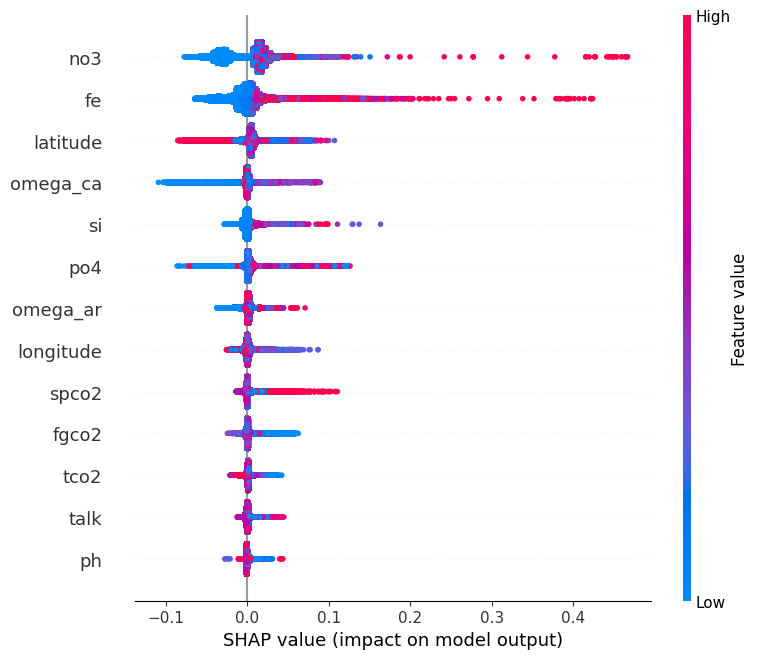

In [122]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(Xy_test[merged_features])

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], Xy_test[merged_features].iloc[0,:])

# Summarize the effects of all the features
shap.summary_plot(shap_values, Xy_test[merged_features])

## Next step: Adding salinity

In [110]:
xys_salt = {(r[0],r[1]) for r in salt_df[['latitude', 'longitude']].values}
xys_merged = {(r[0],r[1]) for r in merged_df[['latitude', 'longitude']].values}

In [109]:
len(xys_salt)

3916800

In [111]:
len(xys_merged)

1153662

In [112]:
len(xys_salt.intersection(xys_merged))

0

There are no points in common - to figure out how to merge them we need to see what they look like.

In [114]:
merged_df

,latitude,longitude,fgco2,omega_ar,omega_ca,ph,spco2,talk,tco2,fe,no3,po4,si,chl,phyc
0,-12.375,45.125,-0.110034,3.446306,5.199481,8.035338,409.610870,2292.652100,1987.368652,0.000061,0.000398,0.026926,0.499061,0.016176,0.218731
1,73.500,-8.250,5.931731,1.733141,2.757106,8.117337,325.349091,2282.134827,2126.286926,0.000059,1.323279,0.103620,0.587495,0.027842,0.096755
2,-38.625,171.125,2.691503,2.686699,4.178655,8.094999,358.161682,2323.055176,2075.048584,0.000014,0.006203,0.041830,0.299250,0.047489,0.301418
3,-36.125,38.625,3.318564,2.959258,4.579558,8.106160,348.271515,2337.646240,2064.160156,0.000020,0.077017,0.051725,0.318254,0.077063,0.333928
4,24.125,-81.875,-0.377263,3.957772,5.911628,8.037149,414.877625,2392.969727,2041.518555,0.000182,0.001371,0.000477,0.397475,0.029105,0.207790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153657,28.750,136.000,0.464342,3.492145,5.266522,8.045138,394.884834,2264.300476,1956.536285,0.000045,0.000950,0.004471,0.531683,0.014485,0.147185
1153658,54.875,-143.625,1.329782,1.715211,2.717761,8.041293,391.195190,2175.042480,2022.784058,0.000012,2.219215,0.224999,3.336908,0.043837,0.162506
1153659,2.875,-40.375,-0.384845,3.802696,5.692340,8.033709,416.504974,2355.795410,2020.633423,0.000045,0.000787,0.012432,0.274529,0.016103,0.214477
1153660,13.250,112.250,0.036770,3.473380,5.220406,8.033383,397.265816,2192.698975,1891.548767,0.000219,0.000761,0.006116,0.805375,0.024369,0.236246


In [150]:
xys_salt_0 = {xy for xy in xys_salt if abs(xy[1]+105) <1 and abs(xy[0])<1}
xys_merg_0 = {xy for xy in xys_merged if abs(xy[1]+105) <1 and abs(xy[0])<1}

In [151]:
x_s_0 = []
y_s_0 = []
for xy in xys_salt_0:
    x_s_0.append(xy[0])
    y_s_0.append(xy[1])

x_c_0 = []
y_c_0 = []
for xy in xys_merg_0:
    x_c_0.append(xy[0])
    y_c_0.append(xy[1])

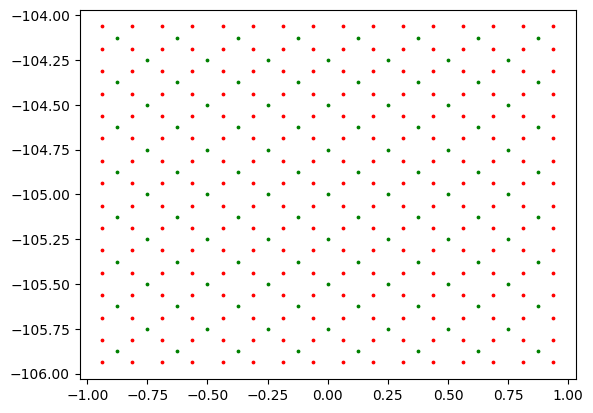

In [155]:
plt.scatter(x=x_s_0,y=y_s_0,c='r',s=3)
plt.scatter(x=x_c_0,y=y_c_0,c='g',s=3)

The first two datasets essentially had the same resolution, but were shifted.

Here, the salinity data has a finer resolution and the points are shifted.

## Merging with salinity dataframe